In [75]:
import numpy as np
import csv
import gc

In [76]:
# This function reads the csv file and keeps the useful columns
def load_raw_data(filename):
    '''This function reads a raw csv file and keeps all the useful columns 
    INPUT: the name of the file
    OUTPUT: a matrix of raw features and a vector with the postal codes'''
    X = []
    y = []
    with open(filename, newline='',encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        count = 0
        fields = 0
        for row in reader:
            if (count == 0):
                count += 1
                fields = len(row)
            # We keep only the questions with a valid ID and a valid number of rows
            if ((len(row[0])==60) and len(row)==fields) :
                data_vector = np.array(row)
                dvx = data_vector[[2,9]]
                dvx = np.append(dvx,data_vector[11:])
                X.append(dvx)
                dvy = data_vector[10]
                y.append(dvy)
                # We do this in order to free up memory
                data_vector = None
        #  call the garbage collector
        gc.collect()
    return X, y

# This function creates a column vector from a matrix
def column(matrix, i):
    return [row[i] for row in matrix]

In [77]:
# Charging the data from the csv file
X,y = load_raw_data("LA_TRANSITION_ECOLOGIQUE.csv")

# Preprocessing of the ZIP code. We just need to convert it from str to int
y = np.array(y)
y = np.asarray(y,dtype='int')

In [78]:
import re
import nltk #import the natural language toolkit library
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import FrenchStemmer #import the French stemming library
from nltk.corpus import stopwords #import stopwords from nltk corpus
from collections import Counter #allows for counting the number of occurences in a list

def get_tokens(raw,encoding='utf8'):
    '''get the nltk tokens from a text'''
    tokens = nltk.word_tokenize(raw) #tokenize the raw UTF-8 text
    return tokens

def get_nltk_text(raw,encoding='utf8'):
    '''create an nltk text using the passed argument (raw) after filtering out the commas'''
    #turn the raw text into an nltk text object
    no_commas = re.sub(r'[.|,|\'|;|\"|(|)|’]',' ', raw) #filter out all the commas, periods, and appostrophes using regex
    tokens = nltk.word_tokenize(no_commas) #generate a list of tokens from the raw text
    text=nltk.Text(tokens,encoding) #create a nltk text from those tokens
    return text

def no_accents(raw,encoding='utf8'):
    '''turns any special character to standard ones.'''
    no_accent_a = re.sub(r'[à|â]','a', raw)
    no_accent_c = re.sub(r'[ç]','c', no_accent_a)
    no_accent_e = re.sub(r'[è|é|ê|ë]','e', no_accent_c)
    no_accent_i = re.sub(r'[î|ï]','i', no_accent_e)
    no_accent_o = re.sub(r'[ô]','o', no_accent_i)
    no_accent_u = re.sub(r'[û|ù|ü]','u', no_accent_o)
    
    return no_accent_u

def get_stopswords(type="veronis"):
    '''returns the veronis stopwords in unicode, or if any other value is passed, it returns the default nltk french stopwords'''
    if type=="veronis":
        #VERONIS STOPWORDS
        raw_stopword_list = ["Ap.", "Apr.", "GHz", "MHz", "USD", "a", "afin", "ah", "ai", "aie", "aient", "aies", "ait", "alors", "après", "as", "attendu", "au", "au-delà", "au-devant", "aucun", "aucune", "audit", "auprès", "auquel", "aura", "aurai", "auraient", "aurais", "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autour", "autre", "autres", "autrui", "aux", "auxdites", "auxdits", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez", "aviez", "avions", "avons", "ayant", "ayez", "ayons", "b", "bah", "banco", "ben", "bien", "bé", "c", "c'", "c'est", "c'était", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cents", "cependant", "certain", "certaine", "certaines", "certains", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "cf.", "cg", "cgr", "chacun", "chacune", "chaque", "chez", "ci", "cinq", "cinquante", "cinquante-cinq", "cinquante-deux", "cinquante-et-un", "cinquante-huit", "cinquante-neuf", "cinquante-quatre", "cinquante-sept", "cinquante-six", "cinquante-trois", "cl", "cm", "cm²", "comme", "contre", "d", "d'", "d'après", "d'un", "d'une", "dans", "de", "depuis", "derrière", "des", "desdites", "desdits", "desquelles", "desquels", "deux", "devant", "devers", "dg", "différentes", "différents", "divers", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dl", "dm", "donc", "dont", "douze", "du", "dudit", "duquel", "durant", "dès", "déjà", "e", "eh", "elle", "elles", "en", "en-dehors", "encore", "enfin", "entre", "envers", "es", "est", "et", "eu", "eue", "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eûmes", "eût", "eûtes", "f", "fait", "fi", "flac", "fors", "furent", "fus", "fusse", "fussent", "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gr", "h", "ha", "han", "hein", "hem", "heu", "hg", "hl", "hm", "hm³", "holà", "hop", "hormis", "hors", "huit", "hum", "hé", "i", "ici", "il", "ils", "j", "j'", "j'ai", "j'avais", "j'étais", "jamais", "je", "jusqu'", "jusqu'au", "jusqu'aux", "jusqu'à", "jusque", "k", "kg", "km", "km²", "l", "l'", "l'autre", "l'on", "l'un", "l'une", "la", "laquelle", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "lez", "lors", "lorsqu'", "lorsque", "lui", "lès", "m", "m'", "ma", "maint", "mainte", "maintes", "maints", "mais", "malgré", "me", "mes", "mg", "mgr", "mil", "mille", "milliards", "millions", "ml", "mm", "mm²", "moi", "moins", "mon", "moyennant", "mt", "m²", "m³", "même", "mêmes", "n", "n'avait", "n'y", "ne", "neuf", "ni", "non", "nonante", "nonobstant", "nos", "notre", "nous", "nul", "nulle", "nº", "néanmoins", "o", "octante", "oh", "on", "ont", "onze", "or", "ou", "outre", "où", "p", "par", "par-delà", "parbleu", "parce", "parmi", "pas", "passé", "pendant", "personne", "peu", "plus", "plus_d'un", "plus_d'une", "plusieurs", "pour", "pourquoi", "pourtant", "pourvu", "près", "puisqu'", "puisque", "q", "qu", "qu'", "qu'elle", "qu'elles", "qu'il", "qu'ils", "qu'on", "quand", "quant", "quarante", "quarante-cinq", "quarante-deux", "quarante-et-un", "quarante-huit", "quarante-neuf", "quarante-quatre", "quarante-sept", "quarante-six", "quarante-trois", "quatorze", "quatre", "quatre-vingt", "quatre-vingt-cinq", "quatre-vingt-deux", "quatre-vingt-dix", "quatre-vingt-dix-huit", "quatre-vingt-dix-neuf", "quatre-vingt-dix-sept", "quatre-vingt-douze", "quatre-vingt-huit", "quatre-vingt-neuf", "quatre-vingt-onze", "quatre-vingt-quatorze", "quatre-vingt-quatre", "quatre-vingt-quinze", "quatre-vingt-seize", "quatre-vingt-sept", "quatre-vingt-six", "quatre-vingt-treize", "quatre-vingt-trois", "quatre-vingt-un", "quatre-vingt-une", "quatre-vingts", "que", "quel", "quelle", "quelles", "quelqu'", "quelqu'un", "quelqu'une", "quelque", "quelques", "quelques-unes", "quelques-uns", "quels", "qui", "quiconque", "quinze", "quoi", "quoiqu'", "quoique", "r", "revoici", "revoilà", "rien", "s", "s'", "sa", "sans", "sauf", "se", "seize", "selon", "sept", "septante", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez", "serions", "serons", "seront", "ses", "si", "sinon", "six", "soi", "soient", "sois", "soit", "soixante", "soixante-cinq", "soixante-deux", "soixante-dix", "soixante-dix-huit", "soixante-dix-neuf", "soixante-dix-sept", "soixante-douze", "soixante-et-onze", "soixante-et-un", "soixante-et-une", "soixante-huit", "soixante-neuf", "soixante-quatorze", "soixante-quatre", "soixante-quinze", "soixante-seize", "soixante-sept", "soixante-six", "soixante-treize", "soixante-trois", "sommes", "son", "sont", "sous", "soyez", "soyons", "suis", "suite", "sur", "sus", "t", "t'", "ta", "tacatac", "tandis", "te", "tel", "telle", "telles", "tels", "tes", "toi", "ton", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "trente-cinq", "trente-deux", "trente-et-un", "trente-huit", "trente-neuf", "trente-quatre", "trente-sept", "trente-six", "trente-trois", "trois", "très", "tu", "u", "un", "une", "unes", "uns", "v", "vs", "vers", "via", "vingt", "vingt-cinq", "vingt-deux", "vingt-huit", "vingt-neuf", "vingt-quatre", "vingt-sept", "vingt-six", "vingt-trois", "vis-à-vis", "voici", "voilà", "vos", "votre", "vous", "w", "x", "y", "z", "zéro", "à", "ç'", "ça", "ès", "étaient", "étais", "était", "étant", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"]
    else:
        #get French stopwords from the nltk kit
        raw_stopword_list = stopwords.words('french') #create a list of all French stopwords
    stopword_list = raw_stopword_list
    #stopword_list = [word.decode('utf8') for word in raw_stopword_list] #make to decode the French stopwords as unicode objects rather than ascii
    return stopword_list

def filter_stopwords(text,stopword_list):
    '''normalizes the words by turning them all lowercase and then filters out the stopwords'''
    lower_words=[w.lower() for w in text] #normalize the words in the text, making them all lowercase
    words=[no_accents(w) for w in lower_words]
    #filtering stopwords
    filtered_words = [] #declare an empty list to hold our filtered words
    for word in words: #iterate over all words from the text
        if word not in stopword_list and word.isalpha() and len(word) > 1: #only add words that are not in the French stopwords list, are alphabetic, and are more than 1 character
            filtered_words.append(word) #add word to filter_words list if it meets the above conditions
    filtered_words.sort() #sort filtered_words list
    return filtered_words

def stem_words(words):
    '''stems the word list using the French Stemmer'''
    #stemming words
    stemmed_words = [] #declare an empty list to hold our stemmed words
    stemmer = FrenchStemmer() #create a stemmer object in the FrenchStemmer class
    for word in words:
        stemmed_word=stemmer.stem(word) #stem the word
        stemmed_words.append(stemmed_word) #add it to our stemmed word list
    stemmed_words.sort() #sort the stemmed_words
    return stemmed_words

def sort_dictionary(dictionary):
    '''returns a sorted dictionary (as tuples) based on the value of each key'''
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

def normalize_counts(counts):
    '''returns the frequency of tokens for each text'''
    total = sum(counts.values())
    return dict((word, float(count)/total) for word,count in counts.items())



[nltk_data] Downloading package punkt to /Users/QQINO/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/QQINO/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
def preprocessing_text(word_vector):
    '''This function takes a vector of questions and filters out all the spaces, the suffixes
    and prefixes, the special charaters.
    INPUT: a vector of texts
    OUTPUT a vector of dictionaries which represents a text'''
    vector = []
    for i in word_vector:
        # TODO: Remove tabs (\t) too
        raw = re.sub(r'\s+|\t', ' ',i) #remove the excess whitespace from the raw text
        text = get_nltk_text(raw)
        stopword_list = get_stopswords()
        filtered_text = filter_stopwords(text,stopword_list)
        stemed_text = stem_words(filtered_text)
        vector.append(stemed_text)
    gc.collect()
    return vector

def preprocessing_yesno(word_vector):
    '''This function takes a vector of yes and no and make them into an int (yes 1)(no -1)(unanswered 0)
    INPUT: a vector of yes and no answers
    OUTPUT a vector of int according to the classification'''
    vector = []
    for i in word_vector:
        if i == 'Oui':
            vector.append(1)
        elif i == 'Non':
            vector.append(-1)
        else: vector.append(0)
    return vector

def preprocessing_categories(word_vector,category_vector):
    '''This function labels the an array of words which represents categories
    INPUT: a vector of answers, a vector of categories to label the answers
    OUTPUT a vector with the label for each category
    Nb: 0 if No category'''
    vector = []
    for i in word_vector:
        found = False
        for j in range(len(category_vector)):
            if i == category_vector[j]:
                found = True
                vector.append(j+1)
                break
        if not found : vector.append(0)
    return vector

In [80]:
def preprocessing_raw_data(X,y,array_yes_no,array_category,category_labels):
    '''This function process all the columns of features and fussion them in
    a unique array with the zip code
    INPUT: raw features, zip code, column number of yes/no questions and text labels
    for category question
    OUTPUT: the processed data whose columns are in this order:
        Title, Category, Questions 1 - 14, Zip code'''
    # Preprocessing questions
    questions = []
    n = len(X[0])
    for i in range(n):
        print("There are",len(X[0])," iterations. Count: ",i)
        if i in array_yes_no:
            questions.append(preprocessing_yesno(column(X,i)))
        elif i in array_category:
            questions.append(preprocessing_categories(column(X,i),category_labels.pop(0)))
        else:
            questions.append(preprocessing_text(column(X,i)))

    questions_trans = np.transpose(np.array(questions))
    output = np.array(y).reshape((len(y),1))
    data = np.concatenate((questions_trans,output),axis=1)
    gc.collect()
    return data

In [81]:
# Treatement of Transition_ecologique dataset
user_category = ['Citoyen / Citoyenne','Élu / élue et Institution',
                 'Organisation à but lucratif','Organisation à but non lucratif']

mobilite_category = ['Oui','Non',"Je n'utilise pas la voiture pour des déplacements quotidiens"]
labels = [user_category,mobilite_category]
data = preprocessing_raw_data(X,y,[4,6,10],[1,12],labels)

There are 18  iterations. Count:  0
There are 18  iterations. Count:  1
There are 18  iterations. Count:  2
There are 18  iterations. Count:  3
There are 18  iterations. Count:  4
There are 18  iterations. Count:  5
There are 18  iterations. Count:  6
There are 18  iterations. Count:  7
There are 18  iterations. Count:  8
There are 18  iterations. Count:  9
There are 18  iterations. Count:  10
There are 18  iterations. Count:  11
There are 18  iterations. Count:  12
There are 18  iterations. Count:  13
There are 18  iterations. Count:  14
There are 18  iterations. Count:  15
There are 18  iterations. Count:  16
There are 18  iterations. Count:  17


In [128]:
def find_zip_codes_by_town(density_threshold,filename='city_information.tsv'):
    '''This function splits up the zip codes of a file into two categories according to a density threshold
    INPUT: density threshold, file name of the reference library
    OUTPUT: set of zip codes for cities, a set of zip codes for villages'''
    codes_cities = set()
    tmp_code_cities = set()
    codes_villages = set()
    tmp_code_villages = set()
    with open(filename, newline='',encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        for row in reader:
            # We keep only the questions with a valid ID and a valid number of rows
            density = -1
            if row[3] != '' and row[4] != '':
                density = float(row[3]) / float(row[4])
            if density >= density_threshold:
                codes_cities.add(row[1])
            elif density != -1: codes_villages.add(row[1])
    tmp_code_cities = codes_cities.copy()
    tmp_code_villages = codes_villages.copy()
    for code in tmp_code_cities:
        match = re.search('-',code)
        if (match != None):
            codes_cities.remove(code)
            split_codes = re.split('-', code)
            for i in split_codes:
                codes_cities.add(i)
    for code in tmp_code_villages:
        match = re.search('-',code)
        if (match != None):
            codes_villages.remove(code)
            split_codes = re.split('-', code)
            for i in split_codes:
                codes_villages.add(i)
    #  call the garbage collector
    gc.collect()
    return codes_cities,codes_villages

def city_village_classifier(density_threshold,data):
    '''This function tags the entries of a data set according to their population density. If it is more than
    a given threshold, the label is 1, -1 otherwise
    INPUT: the density threshold, a dataset
    OUTPUT: the classified dataset'''
    city_zip_codes , village_zip_codes = find_zip_codes_by_town(density_threshold)
    classified_data = []
    class_vector = []
    for entry in data:
        if str(entry[-1]) in city_zip_codes:
            classified_data.append(entry)
            class_vector.append(1)
        elif str(entry[-1]) in village_zip_codes: 
            classified_data.append(entry)
            class_vector.append(-1)
    classified_data = np.array(classified_data)
    classified_data = np.delete(classified_data,len(classified_data[0])-1,1)
    class_vector = np.array(class_vector).reshape((len(class_vector),1))
    classified_data = np.append(classified_data,class_vector,axis=1)
    #  call the garbage collector
    gc.collect()
    return classified_data

In [105]:
classified_data = city_village_classifier(10000,data)

In [39]:
import gzip
import gensim 


In [106]:
model = gensim.models.Word2Vec(
        column(data,5),
        size=300,
        window=10,
        min_count=2,
        workers=10,
        sg=1,
        sorted_vocab=1)


In [108]:
model.train(column(data,5), total_examples=len(column(data,5)), epochs=100)

(49007224, 57800200)

In [68]:
a = model.wv.get_keras_embedding(train_embeddings=False)
print(a)

In [ ]:
b = model.wv.get_vector(w1)


In [169]:
def sent2vec(data, yes_no_array):
    '''
    '''
    filtered_data = []
    for i in range(len(data[0])-1):
        print("Processing column ",i," of 17")
        if i in yes_no_array:
            filtered_data.append(column(data,i))
        else:
            model = gensim.models.Word2Vec(
                    column(data,i),
                    size=300,
                    window=10,
                    min_count=0,
                    workers=10,
                    sg=1,
                    sorted_vocab=1)
            model.train(column(data,i),total_examples=len(column(data,i)), epochs=50)
            weights = []
            for entry in column(data,i):
                words = set(entry)
                entry_weight = np.zeros(300)
                for j in words:
                    entry_weight += model.wv.get_vector(j)
                if (len(words)>0):
                    entry_weight = np.array(entry_weight)/len(words)
                weights.append(entry_weight)
            filtered_data.append(weights)
                
    filtered_data.append(column(data,-1))
    #  call the garbage collector
    gc.collect()
        
    return filtered_data

def get_set_features(data,column):
    '''This function return a feature (column) of a dataset
    '''
    a_data = np.array(data)
    features = a_data[:,column]
    features = np.array([np.asarray(i) for i in features])
    return features

In [170]:
data = sent2vec(classified_data,[1,4,6,10,12])


Processing column  0  of 17
Processing column  1  of 17
Processing column  2  of 17
Processing column  3  of 17
Processing column  4  of 17
Processing column  5  of 17
Processing column  6  of 17
Processing column  7  of 17
Processing column  8  of 17
Processing column  9  of 17
Processing column  10  of 17
Processing column  11  of 17
Processing column  12  of 17
Processing column  13  of 17
Processing column  14  of 17
Processing column  15  of 17
Processing column  16  of 17
Processing column  17  of 17


In [171]:
data = np.array(data).T

In [172]:
np.shape(get_set_features(data,7))


(91898, 300)

In [196]:
# Test relevance
from time import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
# Code from scikit-learn
import itertools
from sklearn.preprocessing import StandardScaler

# Shuffle data randomly
indeces=np.arange(91898)
np.random.shuffle(indeces)
WordVectors = get_set_features(data,11)
y = get_set_features(data,-1)
Xp=WordVectors[indeces]
yp=y[indeces]

# Scale data 
scaler = StandardScaler()
scaler.fit(Xp)
Xps=scaler.transform(Xp)

# Feature selection

# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Feature extraction
test = SelectKBest(score_func=mutual_info_classif, k=10)
fit = test.fit(Xps,yp)

# Summarize scores
np.set_printoptions(precision=3)
cont=0
for a in fit.scores_:
    if a>0.01:
        cont=cont+1

#revers indices
indices = np.argsort(fit.scores_)[::-1]
FeatureIndList=[]
# Print the feature ranking
print("Feature ranking:")
print
for f in range(Xps.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], fit.scores_[indices[f]]))
    if fit.scores_[indices[f]]>0.005:
        FeatureIndList.append(indices[f])
        
FinalIndexes=FeatureIndList

Feature ranking:
1. feature 141 (0.009039)
2. feature 116 (0.008387)
3. feature 1 (0.008034)
4. feature 58 (0.007839)
5. feature 202 (0.007292)
6. feature 241 (0.007036)
7. feature 182 (0.007021)
8. feature 200 (0.006976)
9. feature 256 (0.006970)
10. feature 186 (0.006915)
11. feature 135 (0.006749)
12. feature 213 (0.006658)
13. feature 10 (0.006603)
14. feature 87 (0.006546)
15. feature 106 (0.006482)
16. feature 226 (0.006412)
17. feature 281 (0.006335)
18. feature 61 (0.006220)
19. feature 57 (0.006167)
20. feature 79 (0.006143)
21. feature 283 (0.006138)
22. feature 274 (0.006135)
23. feature 34 (0.006116)
24. feature 210 (0.006078)
25. feature 46 (0.006068)
26. feature 190 (0.005989)
27. feature 251 (0.005974)
28. feature 237 (0.005964)
29. feature 265 (0.005962)
30. feature 206 (0.005924)
31. feature 147 (0.005917)
32. feature 229 (0.005894)
33. feature 261 (0.005776)
34. feature 188 (0.005776)
35. feature 44 (0.005768)
36. feature 96 (0.005749)
37. feature 50 (0.005748)
38. fe

In [197]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

QDA : training set
done in 4.627s
Average and std CV score : 0.8311063199255158 +- 0.0027971408856764675
Score :  0.8319912948857454
 
Normalized confusion matrix
[[0.918 0.082]
 [0.8   0.2  ]]


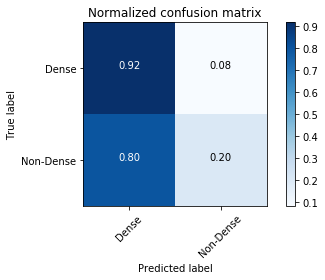

0.1293728338688836


In [198]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

WordVectors = get_set_features(data,11)
yp = get_set_features(data,-1)
Xp=WordVectors[:,FinalIndexes]

Xin = Xp
X_train, X_test, y_train, y_test = train_test_split(Xin , yp , test_size=0.20, random_state=42)


#QDA
print("QDA : training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=Xin, y=np.ravel(yp),cv=5)
qda.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))
print("Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
print("Score : ",qda.score(X_test,y_test))
print(" ")

y_pred = qda.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
class_names=["Dense","Non-Dense"]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
print(matthews_corrcoef(y_test, y_pred))

In [201]:
def feature_selection():
    for i in range(len(data[0])-1):
        if i not in [1,4,6,10,12]:
            # Shuffle data randomly
            indeces=np.arange(91898)
            np.random.shuffle(indeces)
            WordVectors = get_set_features(data,i)
            y = get_set_features(data,-1)
            Xp=WordVectors[indeces]
            yp=y[indeces]

            # Scale data 
            scaler = StandardScaler()
            scaler.fit(Xp)
            Xps=scaler.transform(Xp)

            # Feature selection
            test = SelectKBest(score_func=mutual_info_classif, k=10)
            fit = test.fit(Xps,yp)

            # Summarize scores
            np.set_printoptions(precision=3)
            cont=0
            for a in fit.scores_:
                if a>0.01:
                    cont=cont+1

            #revers indices
            indices = np.argsort(fit.scores_)[::-1]
            FeatureIndList=[]
            # Print the feature ranking
            print("Feature ranking:")
            print
            for f in range(Xps.shape[1]):
                print("%d. feature %d (%f)" % (f + 1, indices[f], fit.scores_[indices[f]]))
                if fit.scores_[indices[f]]>0.005:
                    FeatureIndList.append(indices[f])

            FinalIndexes=FeatureIndList


            yp = y
            Xp=WordVectors[:,FinalIndexes]

            Xin = Xp
            X_train, X_test, y_train, y_test = train_test_split(Xin , yp , test_size=0.20, random_state=42)


            #QDA
            print("QDA : training set")
            t0 = time()
            qda = QuadraticDiscriminantAnalysis()
            qda_score = cross_val_score(qda,X=Xin, y=np.ravel(yp),cv=5)
            qda.fit(X_train,y_train)
            print("done in %0.3fs" % (time() - t0))
            print("Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
            print("Score : ",qda.score(X_test,y_test))
            print(" ")

            y_pred = qda.predict(X_test)
            # Compute confusion matrix
            cnf_matrix = confusion_matrix(y_test, y_pred)

            # Plot normalized confusion matrix
            class_names=["Dense","Non-Dense"]
            plt.figure()
            plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                                  title='Normalized confusion matrix')
            plt.show()
            print(matthews_corrcoef(y_test, y_pred))

Feature ranking:
1. feature 291 (0.006882)
2. feature 222 (0.006634)
3. feature 148 (0.006464)
4. feature 253 (0.006442)
5. feature 162 (0.006428)
6. feature 232 (0.006380)
7. feature 298 (0.006273)
8. feature 75 (0.006236)
9. feature 233 (0.006195)
10. feature 204 (0.006144)
11. feature 197 (0.006020)
12. feature 153 (0.005923)
13. feature 38 (0.005904)
14. feature 295 (0.005858)
15. feature 27 (0.005741)
16. feature 28 (0.005704)
17. feature 244 (0.005693)
18. feature 77 (0.005692)
19. feature 41 (0.005657)
20. feature 24 (0.005604)
21. feature 52 (0.005593)
22. feature 267 (0.005589)
23. feature 127 (0.005571)
24. feature 20 (0.005570)
25. feature 203 (0.005552)
26. feature 126 (0.005519)
27. feature 12 (0.005512)
28. feature 29 (0.005510)
29. feature 124 (0.005499)
30. feature 164 (0.005491)
31. feature 258 (0.005490)
32. feature 199 (0.005485)
33. feature 60 (0.005462)
34. feature 115 (0.005451)
35. feature 46 (0.005435)
36. feature 154 (0.005420)
37. feature 243 (0.005377)
38. fe

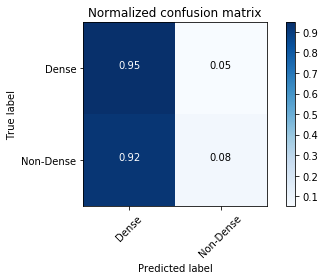

0.034049620861589726
Feature ranking:
1. feature 59 (0.005484)
2. feature 5 (0.005373)
3. feature 288 (0.005314)
4. feature 79 (0.005268)
5. feature 193 (0.005069)
6. feature 83 (0.004999)
7. feature 151 (0.004839)
8. feature 14 (0.004740)
9. feature 267 (0.004559)
10. feature 268 (0.004513)
11. feature 260 (0.004500)
12. feature 275 (0.004438)
13. feature 128 (0.004421)
14. feature 70 (0.004413)
15. feature 146 (0.004407)
16. feature 149 (0.004405)
17. feature 21 (0.004265)
18. feature 270 (0.004220)
19. feature 276 (0.004217)
20. feature 189 (0.004143)
21. feature 74 (0.004107)
22. feature 61 (0.004105)
23. feature 286 (0.004102)
24. feature 68 (0.004033)
25. feature 249 (0.003990)
26. feature 232 (0.003983)
27. feature 98 (0.003972)
28. feature 298 (0.003972)
29. feature 259 (0.003963)
30. feature 174 (0.003871)
31. feature 202 (0.003867)
32. feature 181 (0.003827)
33. feature 271 (0.003809)
34. feature 71 (0.003803)
35. feature 284 (0.003791)
36. feature 15 (0.003771)
37. feature 1

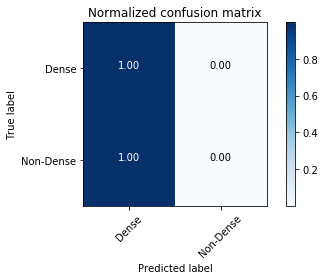

0.005391117527315402
Feature ranking:
1. feature 105 (0.005805)
2. feature 261 (0.004099)
3. feature 53 (0.003920)
4. feature 158 (0.003891)
5. feature 141 (0.003730)
6. feature 227 (0.003577)
7. feature 80 (0.003543)
8. feature 286 (0.003495)
9. feature 280 (0.003484)
10. feature 243 (0.003367)
11. feature 246 (0.003366)
12. feature 272 (0.003362)
13. feature 116 (0.003351)
14. feature 168 (0.003263)
15. feature 126 (0.003262)
16. feature 102 (0.003262)
17. feature 122 (0.003253)
18. feature 79 (0.003252)
19. feature 25 (0.003147)
20. feature 208 (0.003139)
21. feature 108 (0.003133)
22. feature 7 (0.003112)
23. feature 287 (0.003067)
24. feature 99 (0.003061)
25. feature 140 (0.003035)
26. feature 244 (0.003022)
27. feature 117 (0.002980)
28. feature 64 (0.002955)
29. feature 57 (0.002954)
30. feature 145 (0.002925)
31. feature 233 (0.002919)
32. feature 103 (0.002908)
33. feature 179 (0.002887)
34. feature 18 (0.002856)
35. feature 35 (0.002824)
36. feature 262 (0.002821)
37. featur

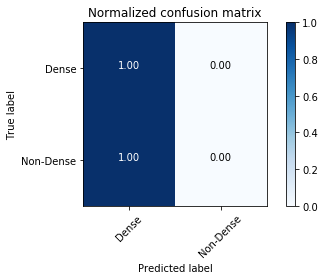

/Users/QQINO/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0
Feature ranking:
1. feature 96 (0.007727)
2. feature 269 (0.007174)
3. feature 117 (0.006596)
4. feature 282 (0.006589)
5. feature 207 (0.006529)
6. feature 276 (0.006524)
7. feature 124 (0.006518)
8. feature 34 (0.006507)
9. feature 262 (0.006453)
10. feature 169 (0.006373)
11. feature 54 (0.006316)
12. feature 215 (0.006307)
13. feature 195 (0.006215)
14. feature 187 (0.006198)
15. feature 63 (0.006093)
16. feature 94 (0.006070)
17. feature 171 (0.006059)
18. feature 66 (0.006038)
19. feature 75 (0.006005)
20. feature 154 (0.005983)
21. feature 87 (0.005967)
22. feature 65 (0.005967)
23. feature 103 (0.005904)
24. feature 182 (0.005888)
25. feature 101 (0.005876)
26. feature 180 (0.005855)
27. feature 192 (0.005791)
28. feature 73 (0.005787)
29. feature 186 (0.005725)
30. feature 67 (0.005681)
31. feature 4 (0.005637)
32. feature 290 (0.005633)
33. feature 40 (0.005625)
34. feature 42 (0.005591)
35. feature 99 (0.005499)
36. feature 238 (0.005495)
37. feature 204 (0.005478)
38. f

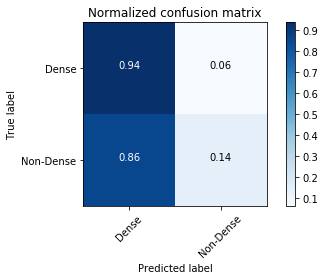

0.10009621020602884
Feature ranking:
1. feature 271 (0.008172)
2. feature 41 (0.007836)
3. feature 57 (0.006268)
4. feature 76 (0.006195)
5. feature 219 (0.006123)
6. feature 63 (0.005859)
7. feature 10 (0.005741)
8. feature 139 (0.005593)
9. feature 171 (0.005494)
10. feature 79 (0.005352)
11. feature 266 (0.005235)
12. feature 220 (0.005096)
13. feature 229 (0.004990)
14. feature 3 (0.004881)
15. feature 197 (0.004874)
16. feature 221 (0.004863)
17. feature 223 (0.004817)
18. feature 11 (0.004790)
19. feature 255 (0.004713)
20. feature 288 (0.004659)
21. feature 61 (0.004606)
22. feature 103 (0.004603)
23. feature 44 (0.004596)
24. feature 28 (0.004588)
25. feature 292 (0.004558)
26. feature 101 (0.004511)
27. feature 83 (0.004504)
28. feature 232 (0.004477)
29. feature 169 (0.004408)
30. feature 52 (0.004398)
31. feature 106 (0.004375)
32. feature 233 (0.004249)
33. feature 116 (0.004224)
34. feature 148 (0.004205)
35. feature 172 (0.004198)
36. feature 51 (0.004188)
37. feature 241

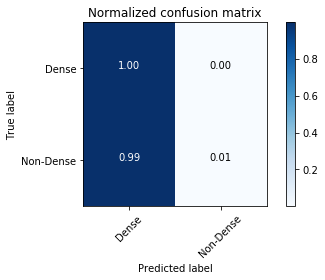

0.0189629101711927
Feature ranking:
1. feature 59 (0.006484)
2. feature 173 (0.006268)
3. feature 220 (0.005188)
4. feature 278 (0.005119)
5. feature 116 (0.005004)
6. feature 53 (0.004950)
7. feature 0 (0.004935)
8. feature 110 (0.004908)
9. feature 31 (0.004887)
10. feature 5 (0.004865)
11. feature 151 (0.004865)
12. feature 103 (0.004787)
13. feature 36 (0.004711)
14. feature 146 (0.004709)
15. feature 263 (0.004683)
16. feature 209 (0.004676)
17. feature 149 (0.004623)
18. feature 88 (0.004619)
19. feature 192 (0.004580)
20. feature 141 (0.004543)
21. feature 222 (0.004476)
22. feature 264 (0.004458)
23. feature 74 (0.004382)
24. feature 77 (0.004265)
25. feature 298 (0.004264)
26. feature 65 (0.004263)
27. feature 34 (0.004256)
28. feature 58 (0.004246)
29. feature 219 (0.004234)
30. feature 120 (0.004224)
31. feature 79 (0.004173)
32. feature 89 (0.004161)
33. feature 66 (0.004068)
34. feature 122 (0.004036)
35. feature 249 (0.004022)
36. feature 135 (0.004016)
37. feature 39 (0.

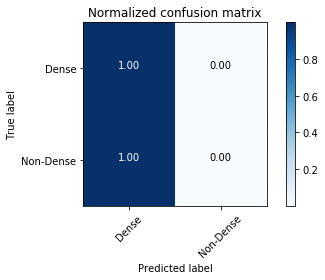

0.0026290612487855553
Feature ranking:
1. feature 210 (0.005889)
2. feature 170 (0.005657)
3. feature 104 (0.005273)
4. feature 212 (0.005196)
5. feature 231 (0.004932)
6. feature 111 (0.004926)
7. feature 220 (0.004879)
8. feature 173 (0.004816)
9. feature 183 (0.004716)
10. feature 274 (0.004648)
11. feature 290 (0.004647)
12. feature 26 (0.004572)
13. feature 130 (0.004570)
14. feature 53 (0.004552)
15. feature 160 (0.004517)
16. feature 57 (0.004503)
17. feature 50 (0.004463)
18. feature 237 (0.004317)
19. feature 225 (0.004240)
20. feature 27 (0.004235)
21. feature 202 (0.004201)
22. feature 105 (0.004196)
23. feature 206 (0.004078)
24. feature 128 (0.004044)
25. feature 117 (0.004023)
26. feature 221 (0.004002)
27. feature 28 (0.003930)
28. feature 121 (0.003871)
29. feature 164 (0.003862)
30. feature 79 (0.003838)
31. feature 268 (0.003826)
32. feature 75 (0.003819)
33. feature 41 (0.003818)
34. feature 118 (0.003771)
35. feature 187 (0.003763)
36. feature 166 (0.003759)
37. fea

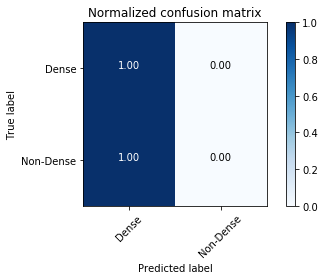

/Users/QQINO/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0
Feature ranking:
1. feature 141 (0.008729)
2. feature 1 (0.008109)
3. feature 182 (0.007923)
4. feature 251 (0.007546)
5. feature 213 (0.007258)
6. feature 112 (0.007219)
7. feature 241 (0.007097)
8. feature 234 (0.006857)
9. feature 64 (0.006844)
10. feature 164 (0.006740)
11. feature 116 (0.006709)
12. feature 186 (0.006678)
13. feature 106 (0.006619)
14. feature 132 (0.006594)
15. feature 202 (0.006478)
16. feature 99 (0.006476)
17. feature 226 (0.006473)
18. feature 57 (0.006460)
19. feature 52 (0.006417)
20. feature 206 (0.006362)
21. feature 108 (0.006359)
22. feature 145 (0.006342)
23. feature 256 (0.006297)
24. feature 33 (0.006295)
25. feature 43 (0.006289)
26. feature 248 (0.006263)
27. feature 44 (0.006261)
28. feature 190 (0.006238)
29. feature 297 (0.006179)
30. feature 209 (0.006173)
31. feature 205 (0.006157)
32. feature 5 (0.006136)
33. feature 265 (0.006128)
34. feature 111 (0.006103)
35. feature 148 (0.005994)
36. feature 253 (0.005986)
37. feature 87 (0.005978)
3

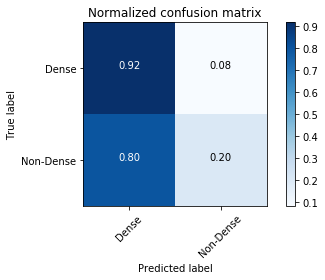

0.13007850751053662
Feature ranking:
1. feature 82 (0.009644)
2. feature 279 (0.008865)
3. feature 109 (0.008708)
4. feature 265 (0.008700)
5. feature 271 (0.008665)
6. feature 132 (0.008638)
7. feature 64 (0.008634)
8. feature 96 (0.008611)
9. feature 33 (0.008595)
10. feature 101 (0.008547)
11. feature 142 (0.008511)
12. feature 39 (0.008503)
13. feature 268 (0.008221)
14. feature 169 (0.008217)
15. feature 87 (0.008152)
16. feature 86 (0.008132)
17. feature 61 (0.008090)
18. feature 120 (0.008001)
19. feature 286 (0.007986)
20. feature 220 (0.007976)
21. feature 277 (0.007932)
22. feature 285 (0.007924)
23. feature 190 (0.007848)
24. feature 219 (0.007846)
25. feature 106 (0.007794)
26. feature 167 (0.007783)
27. feature 229 (0.007757)
28. feature 180 (0.007654)
29. feature 231 (0.007642)
30. feature 263 (0.007596)
31. feature 210 (0.007588)
32. feature 232 (0.007555)
33. feature 258 (0.007553)
34. feature 36 (0.007531)
35. feature 52 (0.007506)
36. feature 236 (0.007460)
37. featur

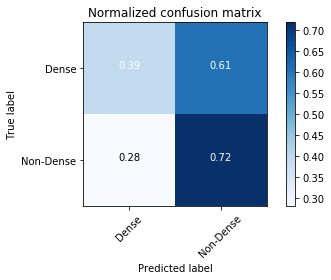

0.07461506687021695
Feature ranking:
1. feature 210 (0.013031)
2. feature 130 (0.012924)
3. feature 297 (0.012545)
4. feature 271 (0.012519)
5. feature 62 (0.012488)
6. feature 146 (0.012004)
7. feature 237 (0.011998)
8. feature 200 (0.011941)
9. feature 10 (0.011893)
10. feature 162 (0.011842)
11. feature 61 (0.011798)
12. feature 240 (0.011728)
13. feature 31 (0.011677)
14. feature 133 (0.011665)
15. feature 17 (0.011644)
16. feature 287 (0.011598)
17. feature 39 (0.011550)
18. feature 189 (0.011530)
19. feature 148 (0.011477)
20. feature 124 (0.011411)
21. feature 37 (0.011381)
22. feature 280 (0.011283)
23. feature 105 (0.011253)
24. feature 245 (0.011191)
25. feature 186 (0.011132)
26. feature 15 (0.011118)
27. feature 275 (0.011033)
28. feature 109 (0.011028)
29. feature 101 (0.011021)
30. feature 114 (0.011011)
31. feature 94 (0.011010)
32. feature 123 (0.010918)
33. feature 242 (0.010849)
34. feature 205 (0.010819)
35. feature 45 (0.010803)
36. feature 234 (0.010700)
37. featur

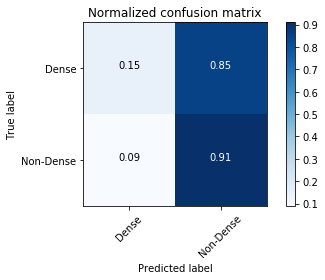

0.05392535340872768
Feature ranking:
1. feature 231 (0.011315)
2. feature 29 (0.011104)
3. feature 161 (0.011001)
4. feature 248 (0.010815)
5. feature 216 (0.010716)
6. feature 68 (0.010637)
7. feature 259 (0.010497)
8. feature 279 (0.010393)
9. feature 16 (0.010267)
10. feature 107 (0.010262)
11. feature 266 (0.010204)
12. feature 191 (0.010006)
13. feature 0 (0.009942)
14. feature 217 (0.009840)
15. feature 282 (0.009645)
16. feature 7 (0.009622)
17. feature 162 (0.009612)
18. feature 146 (0.009473)
19. feature 190 (0.009464)
20. feature 95 (0.009462)
21. feature 6 (0.009403)
22. feature 199 (0.009392)
23. feature 291 (0.009341)
24. feature 26 (0.009337)
25. feature 38 (0.009326)
26. feature 77 (0.009318)
27. feature 32 (0.009313)
28. feature 177 (0.009310)
29. feature 218 (0.009296)
30. feature 142 (0.009242)
31. feature 204 (0.009235)
32. feature 82 (0.009217)
33. feature 187 (0.009207)
34. feature 212 (0.009203)
35. feature 196 (0.009202)
36. feature 115 (0.009179)
37. feature 15 

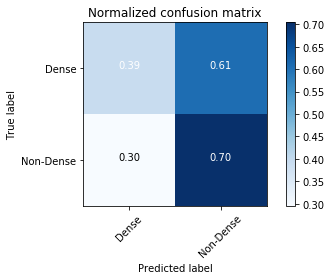

0.06408305986277509
Feature ranking:
1. feature 121 (0.006642)
2. feature 164 (0.005260)
3. feature 79 (0.005123)
4. feature 22 (0.005064)
5. feature 8 (0.004995)
6. feature 145 (0.004919)
7. feature 220 (0.004919)
8. feature 257 (0.004644)
9. feature 172 (0.004596)
10. feature 156 (0.004554)
11. feature 28 (0.004500)
12. feature 274 (0.004498)
13. feature 281 (0.004469)
14. feature 151 (0.004469)
15. feature 125 (0.004419)
16. feature 99 (0.004416)
17. feature 87 (0.004292)
18. feature 26 (0.004281)
19. feature 184 (0.004262)
20. feature 227 (0.004182)
21. feature 101 (0.004167)
22. feature 120 (0.004154)
23. feature 37 (0.004142)
24. feature 90 (0.004142)
25. feature 44 (0.003941)
26. feature 232 (0.003911)
27. feature 85 (0.003901)
28. feature 202 (0.003900)
29. feature 299 (0.003862)
30. feature 239 (0.003854)
31. feature 193 (0.003835)
32. feature 224 (0.003786)
33. feature 190 (0.003695)
34. feature 296 (0.003686)
35. feature 238 (0.003660)
36. feature 135 (0.003660)
37. feature 

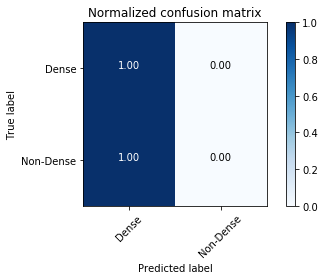

/Users/QQINO/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0
Feature ranking:
1. feature 295 (0.006761)
2. feature 291 (0.006468)
3. feature 280 (0.005544)
4. feature 264 (0.005444)
5. feature 59 (0.005392)
6. feature 122 (0.005356)
7. feature 203 (0.005171)
8. feature 276 (0.005058)
9. feature 49 (0.005024)
10. feature 206 (0.004909)
11. feature 138 (0.004842)
12. feature 68 (0.004825)
13. feature 53 (0.004808)
14. feature 60 (0.004763)
15. feature 99 (0.004717)
16. feature 116 (0.004669)
17. feature 106 (0.004643)
18. feature 105 (0.004574)
19. feature 200 (0.004475)
20. feature 46 (0.004441)
21. feature 164 (0.004381)
22. feature 150 (0.004307)
23. feature 155 (0.004287)
24. feature 158 (0.004258)
25. feature 0 (0.004230)
26. feature 23 (0.004229)
27. feature 43 (0.004204)
28. feature 230 (0.004197)
29. feature 97 (0.004183)
30. feature 125 (0.004152)
31. feature 37 (0.004077)
32. feature 12 (0.004070)
33. feature 104 (0.004022)
34. feature 188 (0.004017)
35. feature 260 (0.004004)
36. feature 209 (0.003962)
37. feature 272 (0.003952)
38.

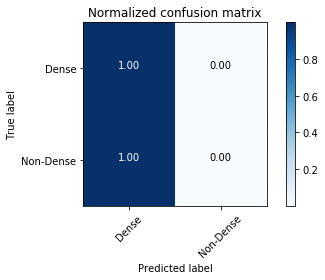

0.005346379297477652


In [202]:
feature_selection()